# [ CNN ] OOD Detection using FSS

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_CNN
from core.data_loader import TRAIN_loader, TEST_loader
from core.fisher_utils_CNN import Calculate_fisher_CNN, Calculate_score_CNN, AUTO_CNN
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# Define Global Variables & Initialize

In [2]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'cifar10': {}, 'fmnist': {}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'cifar10': {}, 'fmnist': {}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'cifar10': {}, 'fmnist': {}}


# CNN

In [3]:
opt = config.CNN_fmnist
model = load_pretrained_CNN(option=opt.train_dist, modelname='VGG11')
model.eval()

acc = 0
loader = TEST_loader(opt.train_dist, opt.train_dist, shuffle=True, normalize=True)
for i, (x,y) in enumerate(loader):
    pred = model(x.float().cuda())
    if torch.argmax(pred).detach().cpu() == y:
        acc += 1
    print(f'{acc/(i+1):.4f}', end='\r')
    if i==300:
        break
torch.cuda.empty_cache()

In [24]:
model

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [4]:
# VGG11
layers = {
    'C1': model.module.features[0],
    'B1': model.module.features[1],
    'C2': model.module.features[4],
    'B2': model.module.features[5],
    'C3': model.module.features[8],
    'B3': model.module.features[9],
    'C4': model.module.features[11],
    'B4': model.module.features[12],
    'C5': model.module.features[15],
    'B5': model.module.features[16],
    'C6': model.module.features[18],
    'B6': model.module.features[19],
    'C7': model.module.features[22],
    'B7': model.module.features[19],
    'C8': model.module.features[25],
    'B8': model.module.features[26],
    'fc': model.module.classifier,
}

In [7]:
# ResNet18
layers = {
    'C1': model.module.conv1,
    'L1B0C1': model.module.layer1[0].conv1,
    'L1B0C2': model.module.layer1[0].conv2,
    'L1B1C1': model.module.layer1[1].conv1,
    'L1B1C2': model.module.layer1[1].conv2,
    'L2B0C1': model.module.layer2[0].conv1,
    'L2B0C2': model.module.layer2[0].conv2,
    'L2B1C1': model.module.layer2[1].conv1,
    'L2B1C2': model.module.layer2[1].conv2,
    'L3B0C1': model.module.layer3[0].conv1,
    'L3B0C2': model.module.layer3[0].conv2,
    'L3B1C1': model.module.layer3[1].conv1,
    'L3B1C2': model.module.layer3[1].conv2,
    'L4B0C1': model.module.layer4[0].conv1,
    'L4B0C2': model.module.layer4[0].conv2,
    'L4B1C1': model.module.layer4[1].conv1,
    'L4B1C2': model.module.layer4[1].conv2,
    'fc': model.module.linear,
}

In [5]:
a, b, _scores = AUTO_CNN(opt, model, layers, max_iter=[10000, 5000], method='Vanilla')

Calculate Score CNN:  84%|████████████████████████████████████████████▊        | 8445/10000 [00:44<00:08, 189.41step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score CNN:  50%|██████████████████████████▍                          | 4999/10000 [00:41<00:41, 119.58step/s]


Files already downloaded and verified


Calculate Score CNN:  50%|██████████████████████████▍                          | 4999/10000 [00:36<00:36, 135.89step/s]


Files already downloaded and verified


Calculate Score CNN:  50%|██████████████████████████▍                          | 4999/10000 [00:35<00:35, 140.56step/s]


Files already downloaded and verified


Calculate Score CNN:  50%|██████████████████████████▍                          | 4999/10000 [00:33<00:33, 147.77step/s]


In [6]:
for lname in layers.keys():
    FISHERs[opt.train_dist][lname] = a[lname] 
    NORM_FACs[opt.train_dist][lname] = b[lname]
for ood in opt.ood_list:
    SCOREs[opt.train_dist][ood] = _scores[ood]

# AUROC curve
auroc = {}
for lname in layers.keys():
    if lname[:1] == 'B':
        continue
    _auroc = {}
    for ood in opt.ood_list:
        args = [
            SCOREs[opt.train_dist][opt.train_dist][lname],
            SCOREs[opt.train_dist][ood][lname],
        ]
        labels = [opt.train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[lname] = _auroc
    
df = pd.DataFrame(auroc).T
df = df.iloc[:, 1:]
df

,svhn,celeba,lsun,cifar10,cifar100,mnist,kmnist,omniglot,notmnist,noise,constant
C1,0.353445,0.562402,0.526184,0.495996,0.531823,0.666081,0.760523,0.998139,0.871858,0.921502,0.291854
C2,0.244147,0.538925,0.513994,0.485506,0.525314,0.904875,0.940047,0.998384,0.977825,0.994953,0.208564
C3,0.221097,0.432954,0.318770,0.315822,0.333053,0.948129,0.962313,0.934513,0.843281,0.999856,0.128224
C4,0.110065,0.423337,0.320823,0.322674,0.319140,0.960579,0.976301,0.982600,0.887547,1.000000,0.014765
C5,0.087007,0.447040,0.381984,0.389146,0.349962,0.962258,0.974742,0.975854,0.899858,0.964007,0.003484
C6,0.196605,0.445159,0.413595,0.429965,0.393693,0.951186,0.971048,0.992560,0.937815,0.986224,0.277655
C7,0.235364,0.369060,0.288083,0.314195,0.291716,0.945922,0.959855,0.976798,0.901680,0.849224,0.441511
C8,0.467909,0.301300,0.309993,0.323437,0.346420,0.755330,0.807232,0.792729,0.731310,0.624969,0.618522
fc,0.155190,0.151663,0.219558,0.222332,0.197953,0.616010,0.728688,0.650919,0.542485,0.773861,0.177524


# 묶어서 보기

In [25]:
aurocs = []
for stuff in ['L1', 'L2', 'L3', 'L4']:
    s = {}
    for ood in opt.ood_list:
        for key in SCOREs[opt.train_dist][ood].keys():
            if key[:2] == stuff:
                try:
                    s[ood] += SCOREs[opt.train_dist][ood][key].copy()
                except:
                    s[ood] = SCOREs[opt.train_dist][ood][key].copy()

    auroc = {}
    for ood in opt.ood_list:
        args = [
            s[opt.train_dist],
            s[ood]
        ]
        labels = [opt.train_dist, ood]
        auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc = pd.Series(auroc)
    aurocs.append(auroc)
    
pd.DataFrame(aurocs)


,cifar10,svhn,celeba,lsun,cifar100,mnist,fmnist,kmnist,omniglot,notmnist,noise,constant
0,0.5,0.051780,0.399600,0.585176,0.478805,0.688882,0.536113,0.626425,0.928088,0.436471,0.997405,0.411803
1,0.5,0.051333,0.460243,0.608530,0.459987,0.791196,0.663585,0.788647,0.942046,0.541215,0.999910,0.085542
2,0.5,0.038323,0.593904,0.561758,0.481271,0.943204,0.685125,0.914031,0.965817,0.732656,0.996481,0.040475
3,0.5,0.273299,0.460933,0.508834,0.432951,0.886166,0.700432,0.870326,0.976842,0.819065,0.988063,0.445127


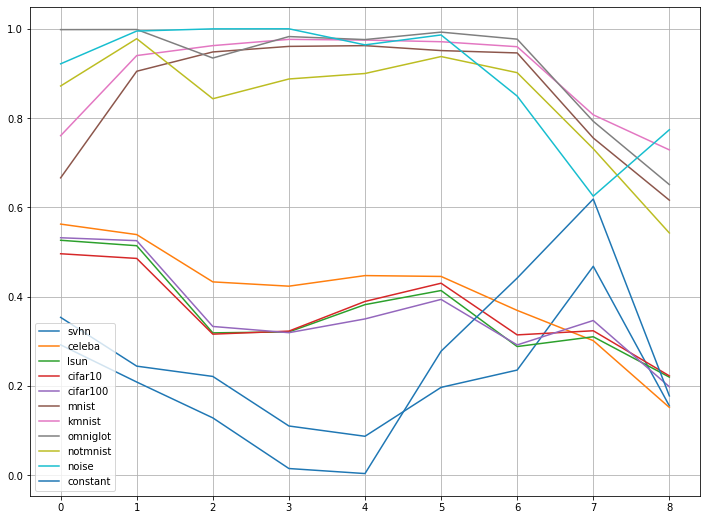

In [7]:
x = range(len(df.index))
fig = plt.figure(figsize=(12, 9))
for ood in df.columns:
    plt.plot(x, df.loc[:, ood], label=ood)
plt.grid()
plt.legend()
plt.show()
fig.savefig('./temp.png')